Import libries
=

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
import re
from nltk.stem.isri import ISRIStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score , accuracy_score , confusion_matrix , f1_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import GaussianNB
import neattext as nt
from nltk.corpus import wordnet
import spacy
from spellchecker import SpellChecker
import plotly.express as px 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/macuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/macuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/macuser/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/macuser/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/macuser/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/macuser/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

load datasets
=

In [2]:
trainSet = pd.read_csv("train.csv")
testSet = pd.read_csv("test.csv")

 Data Exploration
 =

In [3]:
print(trainSet['text'].head())
print('\ntrainSet: '+str(trainSet.shape))

0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object

trainSet: (7613, 5)


In [4]:
trainSet.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [5]:
trainSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
#Check for NULL values 
trainSet.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

**Since the keyword column has more than 30 percent of its data is NULL ,I decided to drop the column**

In [7]:
trainSet = trainSet.drop(['keyword'],axis=1)

In [8]:
# Number of duplicate values
print('Number of duplicates values: '+ str(len(trainSet)-len(trainSet.drop_duplicates())))

Number of duplicates values: 0


**There are no duplicate values in our dataset**


In [9]:
#Sum of each type of target

fig = px.histogram(trainSet, x='target')
fig.update_layout(bargap=0.5)
fig.show()

target1 = trainSet['target'][trainSet['target']==1].count()

target0 = trainSet['target'][trainSet['target']==0].count()

print('Number of tweets written about disasters : '+ str(target1)+'represent '+str(target1/(target0+target1))+' percent')

print("Number of natural tweet : "+ str(target0)+'represent '+str(target0/(target0+target1))+' percent')

Number of tweets written about disasters : 3271represent 0.4296597924602653 percent
Number of natural tweet : 4342represent 0.5703402075397347 percent


Data cleaning
=

**Removeing useless Columns**


In [10]:
trainSet = trainSet.drop(['id'],axis=1) #a unique identifier for each tweet

trainSet = trainSet.drop(['location'],axis=1)



testSet = testSet.drop(['id'],axis=1) #a unique identifier for each tweet

testSet = testSet.drop(['location'],axis=1)

testSet = testSet.drop(['keyword'],axis=1)

In [11]:
#Remove username from text 

numbers_username_occur = trainSet['text'][trainSet['text'].str.contains('@')].count()

print('How many times does username appear in the text: '+str(numbers_username_occur))

trainSet['text'] = trainSet['text'].apply(nt.remove_userhandles)  #remove username from text

testSet['text'] = testSet['text'].apply(nt.remove_userhandles) 



How many times does username appear in the text: 2039


In [12]:
punctuations = '''`÷×؛…<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ''' + string.punctuation
nltk.download('stopwords')
spell = SpellChecker()

def clean_dataset (sen):

    sen = nt.remove_userhandles(sen)  #remove username from text

    sen = sen.lower()
    sen = re.sub(r'\s+[a-zA-Z]\s+'," ",sen) # remove singile char 
    sen = re.sub(r"http\S+", "", sen) #remove links 
    sen = re.sub(r"i'm", "i am", sen) #replace contraction with long form
    sen = re.sub(r"he's", "he is", sen) #replace contraction with long form
    sen = re.sub(r"she's", "she is", sen) #replace contraction with long form
    sen = re.sub(r"it's", "it is", sen) #replace contraction with long form
    sen = re.sub(r"that's", "that is", sen) #replace contraction with long form
    sen = re.sub(r"what's", "that is", sen) #replace contraction with long form
    sen = re.sub(r"where's", "where is", sen) #replace contraction with long form
    sen = re.sub(r"how's", "how is", sen) #replace contraction with long form
    sen = re.sub(r"\'ll", " will", sen) #replace contraction with long form
    sen = re.sub(r"\'ve", " have", sen) #replace contraction with long form
    sen = re.sub(r"\'re", " are", sen) #replace contraction with long form
    sen = re.sub(r"\'d", " would", sen) #replace contraction with long form
    sen = re.sub(r"\'re", " are", sen) #replace contraction with long form
    sen = re.sub(r"won't", "will not", sen) #replace contraction with long form
    sen = re.sub(r"can't", "cannot", sen) #replace contraction with long form
    sen = re.sub(r"n't", " not", sen) #replace contraction with long form
    sen = re.sub(r"n'", "ng", sen) #replace contraction with long form
    sen = re.sub(r"'bout", "about", sen) #replace contraction with long form
    sen = re.sub(r"'til", "until", sen) #replace contraction with long form
    sen = sen.translate({ord(ch):' ' for ch in punctuations}) # remove punctuations
    
    sen = re.sub(" +"," ",sen) #remove extra space
    sen = sen.strip() # remove whitespace 

    return sen

trainSet['text'] = trainSet['text'].apply(clean_dataset)

testSet['text'] = testSet['text'].apply(clean_dataset)

trainSet['text'] = trainSet['text'].apply(nt.remove_non_ascii) # remove non ascii letters i.e emojie

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Check and correct spelling errors
-

In [13]:
# def check_spelling(sen):
#     #check if there are misspelling
#     correct = []
#     text_check = spell.unknown(sen.split())
#     for word in sen.split():
#         if word in text_check:
#             correct.append(spell.correction(word))
#         else:
#              correct.append(word)
#     sen = ' '.join(correct)
#     return sen

# trainSet['text'] = trainSet['text'].apply(check_spelling)

Test our methods
-

In [14]:
tests = "@bbcmtd Wholesale Markets    , !!!! , ablaze https://www.google.com , he'is"

clean_dataset(tests)

'wholesale markets ablaze he is'

feature extraction 
=

In [15]:
#check if our texts contains numbers
def has_numbers(inputString):
     return any(char.isdigit() for char in inputString)

trainSet['containsـnumbers'] = trainSet['text'].apply(has_numbers)

testSet['containsـnumbers'] = testSet['text'].apply(has_numbers)


In [16]:
#Check if our texts contains any country or cities name 
nlp = spacy.load("en_core_web_sm")
def num_of_GPE(sen):
    doc = nlp(sen)
    return [(ent.text, ent.label_) for ent in doc.ents if ent.label_ == 'GPE']

trainSet['GPE'] = trainSet['text'].apply(num_of_GPE)

testSet['GPE'] = testSet['text'].apply(num_of_GPE)


trainSet['does_GPE'] = np.where(trainSet['GPE'].str.len() != 0,1,0)

trainSet.drop(['GPE'],axis=1,inplace=True)
testSet['does_GPE'] = np.where(testSet['GPE'].str.len() != 0,1,0)
testSet.drop(['GPE'],axis=1,inplace=True)


Text Preprocessing
=

**grouping together the inflected forms of a word**

In [17]:
#grouping together the inflected forms of a word

def get_wordnet_pos(word):
    
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def lemma(text):
    # Init Lemmatizer
    lemmatizer = WordNetLemmatizer()
    # Lemmatize text with the appropriate POS tag
    return " ".join([lemmatizer.lemmatize(i, get_wordnet_pos(i)) for i in text.split()])


trainSet['text'] = trainSet['text'].apply(clean_dataset)

testSet['text'] = testSet['text'].apply(clean_dataset)



*Removing stop words*

In [18]:

def remove_stop_word(sen):
    return ' '.join([word for word in sen.split() if word not in stopwords.words("english")])
    
trainSet['text'] = trainSet['text'].apply(remove_stop_word)

testSet['text'] = testSet['text'].apply(remove_stop_word)

*Test our lemmatize and remove_stop_word methods*

In [19]:
example = 'hello I am Faisal from Saudi Arabia'

print(lemma(example))

print(remove_stop_word(example))

hello I be Faisal from Saudi Arabia
hello I Faisal Saudi Arabia


*Word cloud of tweets about disasters*

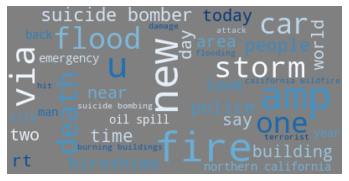

In [20]:
text = " ".join(words for words in trainSet['text'][trainSet['target']==1])
wordcloud = WordCloud(max_font_size=50, max_words=40, colormap="Blues", background_color="gray").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

*Word cloud of natural tweets*

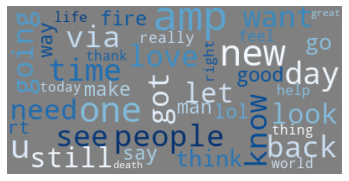

In [21]:
text = " ".join(words for words in trainSet['text'][trainSet['target']==0])
wordcloud = WordCloud(max_font_size=50, max_words=40, colormap="Blues", background_color="gray").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Spliting our dataset
=

In [22]:
X = trainSet.drop(['target'],axis=1)

y = trainSet['target']


In [23]:
x_train,x_test,y_train,y_test =  train_test_split(X,y,test_size = 0.2,random_state = 45)

Building our model
=

In [24]:
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')

def pip_train(clf):
  column_transformer = ColumnTransformer(
    [('tfidf1', tfidfvectorizer, 'text')],
    remainder='passthrough')

  pipe = Pipeline([
                  ('tfidf', column_transformer),
                  ('classify', clf)
                ])
  pipe.fit(x_train,y_train)
  yp = pipe.predict(x_test)
  yp_train = pipe.predict(x_train)
  roc_auc_Score = roc_auc_score(y_test, yp,average='weighted')
  f1 = f1_score(y_test, yp, average='macro')
  precision = precision_score(y_test, yp, average='macro')

  print('f1: '+str(f1))
  print('precision: '+str(precision))
  print('roc_auc_score: '+str(roc_auc_Score))
  print('accuracy_score for test data: '+str(accuracy_score(y_test, yp)))
  print('accuracy_score for train data: '+str(accuracy_score(y_train, yp_train)))
  cf_matrix = confusion_matrix(y_test, yp)
  ax = sns.heatmap(cf_matrix, annot=True, cmap= 'Blues')
  ax.set_xlabel('Predicted values')
  ax.set_ylabel("Actual Values")

  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])
  
  plt.show()

**LogisticRegression**

f1: 0.7957048200363709
precision: 0.8054941903493191
roc_auc_score: 0.791322612973118
accuracy_score for test data: 0.804333552199606
accuracy_score for train data: 0.9341543513957307


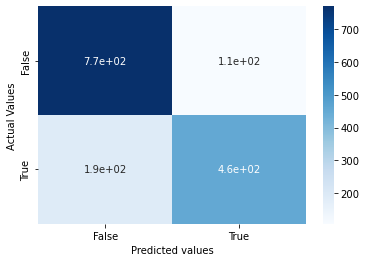

In [25]:
log_reg = LogisticRegression(C = 3, penalty='l2', solver = 'lbfgs', random_state=45,max_iter = 1000)
pip_train(log_reg)


**Support Vector Machines**

f1: 0.7952373304073832
precision: 0.8064840667113394
roc_auc_score: 0.7905145278877572
accuracy_score for test data: 0.804333552199606
accuracy_score for train data: 0.9816091954022989


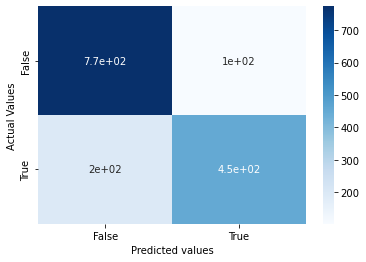

In [26]:
svc = SVC(C = 2, kernel = 'rbf')
pip_train(svc)


**Naive Bayes**

f1: 0.7957519278735554
precision: 0.8033647923266456
roc_auc_score: 0.791963964345451
accuracy_score for test data: 0.8036769533814839
accuracy_score for train data: 0.9160919540229885


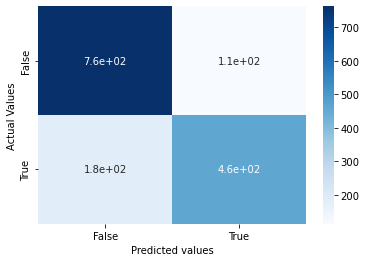

In [27]:
clf = MultinomialNB(alpha=.4)
pip_train(clf)


**Stochastic Gradient Descent**

f1: 0.8014236582199075
precision: 0.820430156960551
roc_auc_score: 0.7951416089715088
accuracy_score for test data: 0.8122127380170716
accuracy_score for train data: 0.9016420361247948


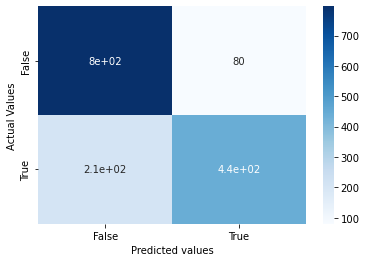

In [28]:
sgd = SGDClassifier(penalty='l2', alpha=.000241)
pip_train(sgd)

**Random Forest Classifier**

f1: 0.7721473287393885
precision: 0.7785244709502249
roc_auc_score: 0.7689564763255772
accuracy_score for test data: 0.7806959947472094
accuracy_score for train data: 0.9816091954022989


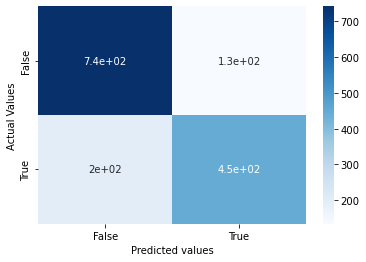

In [29]:
randomforest = RandomForestClassifier(min_samples_split=6)

pip_train(randomforest)

In [30]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
test = testSet
train = X
tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')

def pip_train2(clf):
  column_transformer = ColumnTransformer(
    [('tfidf1', tfidfvectorizer, 'text')],
    remainder='passthrough')

  pipe = Pipeline([
                  ('tfidf', column_transformer),
                  ('classify', clf)
                ])
  pipe.fit(train,y)
  yp = pipe.predict(test)
  yp_train = pipe.predict(train)
  roc_auc_score_train = roc_auc_score(y, yp_train,average='weighted')
  print(roc_auc_score_train)
  print(accuracy_score(y, yp_train))
  return yp
#   print(accuracy_score(y_test, yp))
#   print(accuracy_score(y_train, yp_train))
#   cf_matrix = confusion_matrix(y_test, yp)
#   ax = sns.heatmap(cf_matrix, annot=True, cmap= 'Blues')
#   ax.set_xlabel('Predicted values')
#   ax.set_ylabel("Actual Values")

#   ax.xaxis.set_ticklabels(['False','True'])
#   ax.yaxis.set_ticklabels(['False','True'])
  
#   plt.show()

# log_reg = LogisticRegression(C = 4, penalty='l2', solver = 'lbfgs', random_state=45,max_iter = 2000)
# testSet_pred = pip_train2(log_reg)

# svc = SVC(C = 33, kernel = 'rbf')
# testSet_pred = pip_train2(svc)

# clf = MultinomialNB(alpha=.3)
# testSet_pred = pip_train2(clf)

# # sgd = SGDClassifier(penalty='l2')
# # pip_train2(sgd)

sgd = SGDClassifier(penalty='l2', alpha=.000241)


testSet_pred = pip_train2(sgd)

testSet_finish = pd.read_csv("test.csv")

final_submet = pd.concat([testSet_finish, pd.DataFrame(testSet_pred, columns=['target'])], axis=1)

final_submet.to_csv("final_submet.csv")

0.8706439037359281
0.8840141862603441


In [4]:
from transformers import RobertaTokenizer, TFRobertaModel, RobertaConfig 
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import pandas as pd
from sklearn.model_selection import train_test_split

RuntimeError: Failed to import transformers.models.roberta.modeling_tf_roberta because of the following error (look up to see its traceback):
dlopen(/Users/macuser/miniforge3/envs/env_tf/lib/python3.9/site-packages/tensorflow-plugins/libmetal_plugin.dylib, 6): Symbol not found: _OBJC_CLASS_$_MPSGraphCompilationDescriptor
  Referenced from: /Users/macuser/miniforge3/envs/env_tf/lib/python3.9/site-packages/tensorflow-plugins/libmetal_plugin.dylib (which was built for Mac OS X 12.0)
  Expected in: /System/Library/Frameworks/MetalPerformanceShadersGraph.framework/Versions/A/MetalPerformanceShadersGraph


In [1]:
### --------- Setup Roberta ---------- ###

model_name = 'roberta-base'

# Max length of tokens
max_length = 45

# Load transformers config and set output_hidden_states to False
config = RobertaConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load Roberta tokenizer
tokenizer = RobertaTokenizer.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Roberta model
transformer_roberta_model = TFRobertaModel.from_pretrained(model_name, config = config)

NameError: name 'RobertaConfig' is not defined

In [ ]:
### ------- Build the model ------- ###

# Load the MainLayer
roberta = transformer_roberta_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers RoBERTa model as a layer in a Keras model
roberta_model = roberta(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(roberta_model, training=False)

# Then build your model output
targets = Dense(units=len(data.target_label.value_counts()), kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='target')(pooled_output)
outputs = {'target': targets}

# And combine it all in a model object
model2 = Model(inputs=inputs, outputs=outputs, name='RoBERTa_Binary_Classifier')

# Take a look at the model
model2.summary()